In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 데이터셋 경로
DATASET_PATH = "./caltech101"

# 데이터 변환 및 증강
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 데이터셋 로드 및 분할
full_dataset = datasets.Caltech101(root=DATASET_PATH, download=True, transform=transform)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

# 데이터 로더
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"총 클래스 개수: {len(full_dataset.categories)}")



Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=ca3dbfc8-2ad8-48d2-b20d-2874df2c9227
To: /content/caltech101/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:01<00:00, 109MB/s]


Extracting ./caltech101/caltech101/101_ObjectCategories.tar.gz to ./caltech101/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=cb7ac93c-b785-451d-9428-650644fc682d
To: /content/caltech101/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 58.4MB/s]


Extracting ./caltech101/caltech101/Annotations.tar to ./caltech101/caltech101
총 클래스 개수 (배경 포함): 101


In [3]:
print("클래스 목록:", full_dataset.categories)


클래스 목록: ['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 'schooner', 'scissors', 'scorpion', 'sea_horse', 'snoopy', 'soccer_ball', 

In [ ]:
# Squeeze-and-Excitation 블록
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

# ResNet BasicBlock (기본 블록에 SEBlock 추가)
class SeBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, reduction=16):
        super(SeBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.se = SEBlock(out_channels, reduction)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  # SEBlock 적용
        out += self.shortcut(x)  # 잔차 연결
        out = self.relu(out)
        return out

# SeResNet 모델 정의
class SeResNet(nn.Module):
    def __init__(self, num_classes, block=SeBasicBlock, num_blocks=[2, 2, 2, 2], reduction=16):
        super(SeResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet의 여러 레이어 구성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, reduction=reduction)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, reduction=reduction)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, reduction=reduction)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, reduction=reduction)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride, reduction):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, reduction))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, stride=1, reduction=reduction))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
# ResNet BasicBlock (잔차 연결만 있는 기본 블록)
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)  # 잔차 연결
        out = self.relu(out)
        return out

# ResNet 모델 정의
class ResNet(nn.Module):
    def __init__(self, num_classes, block=BasicBlock, num_blocks=[2, 2, 2, 2]):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet의 여러 레이어 구성
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [ ]:
# 학습 함수
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="cpu"):
    model.to(device)
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)

        # 검증 단계
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%\n")

    return train_losses, val_losses, train_accs, val_accs


In [ ]:
# 테스트 함수
def test_model(model, test_loader, criterion, device="cpu"):
    model.to(device)
    model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss /= test_total  # 평균 손실
    test_acc = 100 * test_correct / test_total  # 정확도 계산
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    return test_loss, test_acc


In [ ]:
# 학습 및 검증 손실 시각화를 위한 그래프 그리기 함수
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(val_accs, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Training and Validation Accuracy")
    plt.show()


Training SeNet...
Epoch [1/50] - Train Loss: 3.6309, Train Acc: 24.16%
Validation Loss: 3.9802, Validation Accuracy: 20.91%

Epoch [2/50] - Train Loss: 2.9352, Train Acc: 35.11%
Validation Loss: 2.9763, Validation Accuracy: 33.28%

Epoch [3/50] - Train Loss: 2.4576, Train Acc: 42.93%
Validation Loss: 2.9739, Validation Accuracy: 36.82%

Epoch [4/50] - Train Loss: 2.1476, Train Acc: 48.79%
Validation Loss: 2.3478, Validation Accuracy: 44.66%

Epoch [5/50] - Train Loss: 1.8846, Train Acc: 52.36%
Validation Loss: 2.1785, Validation Accuracy: 48.12%

Epoch [6/50] - Train Loss: 1.6655, Train Acc: 57.52%
Validation Loss: 2.0524, Validation Accuracy: 50.42%

Epoch [7/50] - Train Loss: 1.4746, Train Acc: 62.14%
Validation Loss: 1.8218, Validation Accuracy: 54.42%

Epoch [8/50] - Train Loss: 1.3294, Train Acc: 65.12%
Validation Loss: 1.7641, Validation Accuracy: 56.73%

Epoch [9/50] - Train Loss: 1.1785, Train Acc: 68.94%
Validation Loss: 1.6066, Validation Accuracy: 60.95%

Epoch [10/50] - Tra

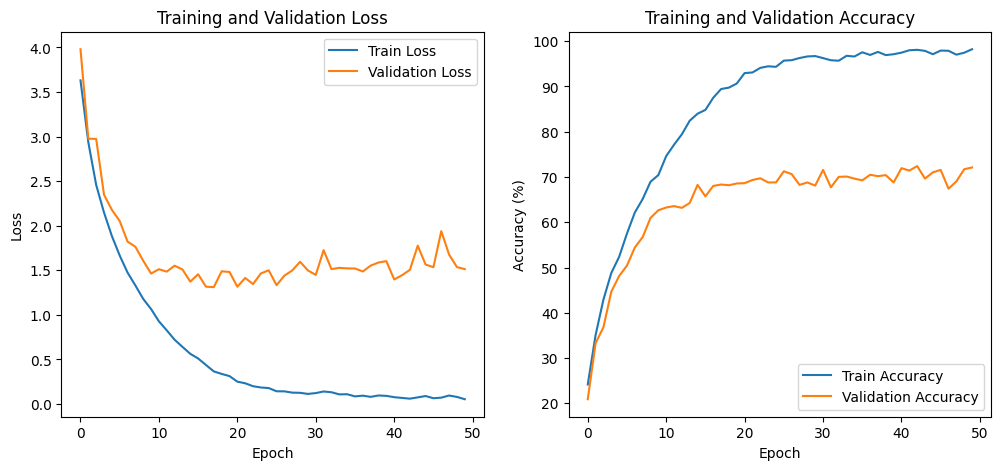

Test Loss: 1.3464, Test Accuracy: 74.37%
Training ResNet...
Epoch [1/50] - Train Loss: 3.9053, Train Acc: 20.37%
Validation Loss: 4.1374, Validation Accuracy: 19.29%

Epoch [2/50] - Train Loss: 3.2513, Train Acc: 30.13%
Validation Loss: 3.4568, Validation Accuracy: 27.75%

Epoch [3/50] - Train Loss: 2.7451, Train Acc: 38.23%
Validation Loss: 3.0282, Validation Accuracy: 33.51%

Epoch [4/50] - Train Loss: 2.3460, Train Acc: 44.71%
Validation Loss: 2.3881, Validation Accuracy: 45.58%

Epoch [5/50] - Train Loss: 2.0934, Train Acc: 49.74%
Validation Loss: 2.1924, Validation Accuracy: 47.58%

Epoch [6/50] - Train Loss: 1.8856, Train Acc: 53.22%
Validation Loss: 2.0776, Validation Accuracy: 50.19%

Epoch [7/50] - Train Loss: 1.6653, Train Acc: 57.70%
Validation Loss: 1.8601, Validation Accuracy: 54.34%

Epoch [8/50] - Train Loss: 1.4911, Train Acc: 62.14%
Validation Loss: 1.8589, Validation Accuracy: 54.65%

Epoch [9/50] - Train Loss: 1.3550, Train Acc: 65.21%
Validation Loss: 1.7930, Valida

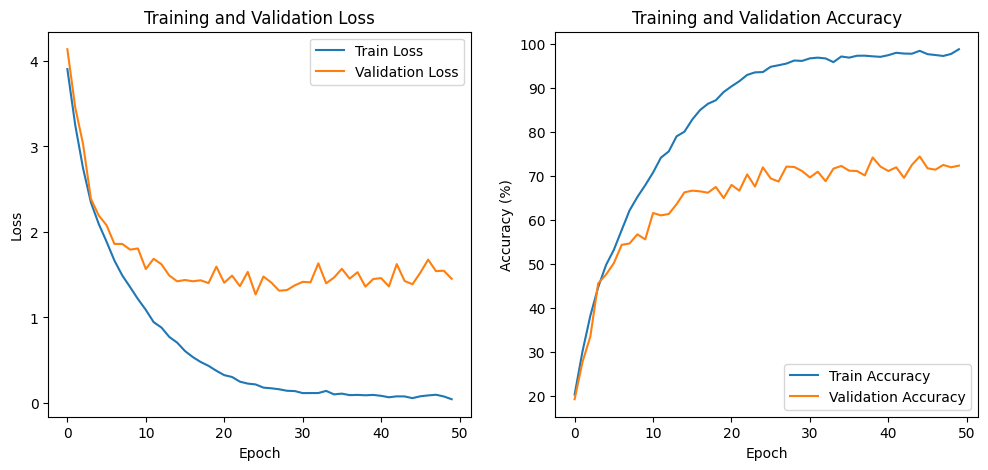

Test Loss: 1.2816, Test Accuracy: 75.67%


In [ ]:
num_epochs = 50
loss_function = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# SeNet 모델 결과를 위한 리스트 초기화
train_losses_seNet, val_losses_seNet, train_accs_seNet, val_accs_seNet = [], [], [], []

# SeNet 모델 학습
seNet = SeResNet(101)
seNet.to(device)
optimizer_seNet = optim.Adam(seNet.parameters(), lr=0.001)
print("Training SeNet...")

train_losses_seNet, val_losses_seNet, train_accs_seNet, val_accs_seNet = train_model(
    seNet, train_loader, val_loader, loss_function, optimizer_seNet, num_epochs, device
)

# SeNet 학습 손실 및 정확도 그래프 출력
plot_metrics(train_losses_seNet, val_losses_seNet, train_accs_seNet, val_accs_seNet)

# SeNet 테스트
test_loss_seNet, test_acc_seNet = test_model(seNet, test_loader, loss_function, device)

# ResNet 모델 결과를 위한 리스트 초기화
train_losses_resNet, val_losses_resNet, train_accs_resNet, val_accs_resNet = [], [], [], []

# ResNet 모델 학습
resNet = ResNet(101)
resNet.to(device)
optimizer_resNet = optim.Adam(resNet.parameters(), lr=0.001)
print("Training ResNet...")

train_losses_resNet, val_losses_resNet, train_accs_resNet, val_accs_resNet = train_model(
    resNet, train_loader, val_loader, loss_function, optimizer_resNet, num_epochs, device
)

# ResNet 학습 손실 및 정확도 그래프 출력
plot_metrics(train_losses_resNet, val_losses_resNet, train_accs_resNet, val_accs_resNet)

# ResNet 테스트
test_loss_resNet, test_acc_resNet = test_model(resNet, test_loader, loss_function, device)


In [ ]:
print(f"SeNet Test Loss: {test_loss_seNet:.4f},SeNet Test Accuracy: {test_acc_seNet:.2f}%")
print(f"ResNet Test Loss: {test_loss_resNet:.4f},ResNet Test Accuracy: {test_acc_resNet:.2f}%")

SeNet Test Loss: 1.3464,SeNet Test Accuracy: 74.37%
ResNet Test Loss: 1.2816,ResNet Test Accuracy: 75.67%


#Caltech-101

* 약 9000개의 컬러 이미지
* 102개의 class (동물, 차량, 사람 등 다양한 사물)
* 각 class마다 약 40~800개의 이미지
* 다양한 크기의 이미지

torchvision 버전이 0.13이상이면 background가 포함되어 있지 않은 101개의 class로 이루어져 있습니다.

#데이터 전처리

1. transforms.Resize() - Caltech-101은 다양한 크기의 이미지로 구성되어 있기 때문에 사용
2. transforms.RandomHorizontalFlip() - 좌우 대칭의 객체를 더 잘 인식할 수 있도록
3. transforms.RandomRotation() - 회전된 이미지도 잘 인식할 수 있도록
4. transforms.ColorJitter() - 색상 변화에 덜 민감하도록
5. transforms.Grayscale(num_output_channels=3) - Caltech-101에는 흑백 이미지도 포함하기 때문에 흑백 이미지를 RGB로 바꾸기 위해 사용
6. transforms.ToTensor() - 이미지를 모델에 입력하기 위해서 PIL 이미지에서 Pytorch Tensor로 변환
7. transforms.Normalize() - RGB 각 채널에 대해 평균과 표준편차를 기준으로 픽셀 값 조정하여 모델이 더 빠르고 안정적으로 학습할 수 있도록


#ResNet-18

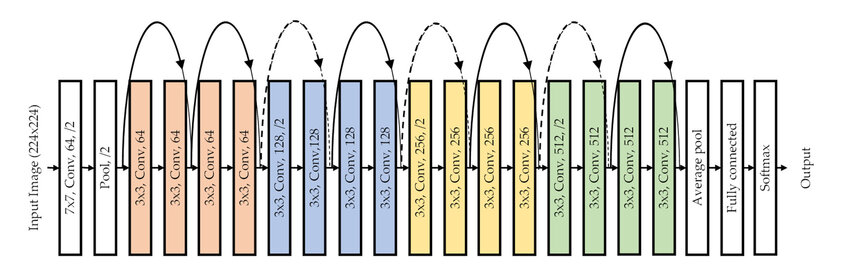

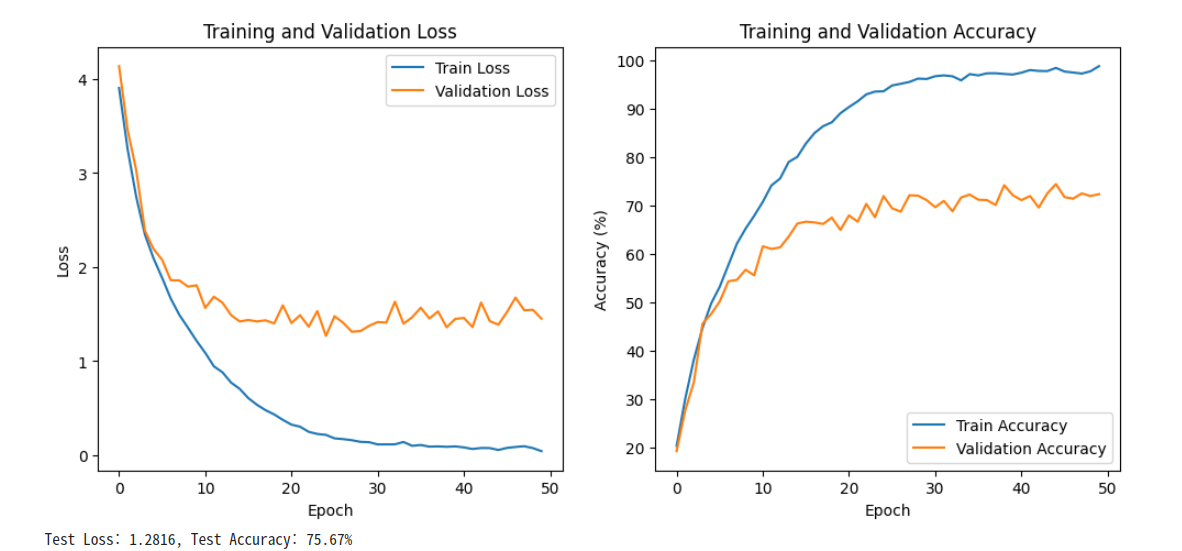

#SENet (with ResNet-18)

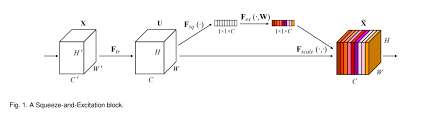

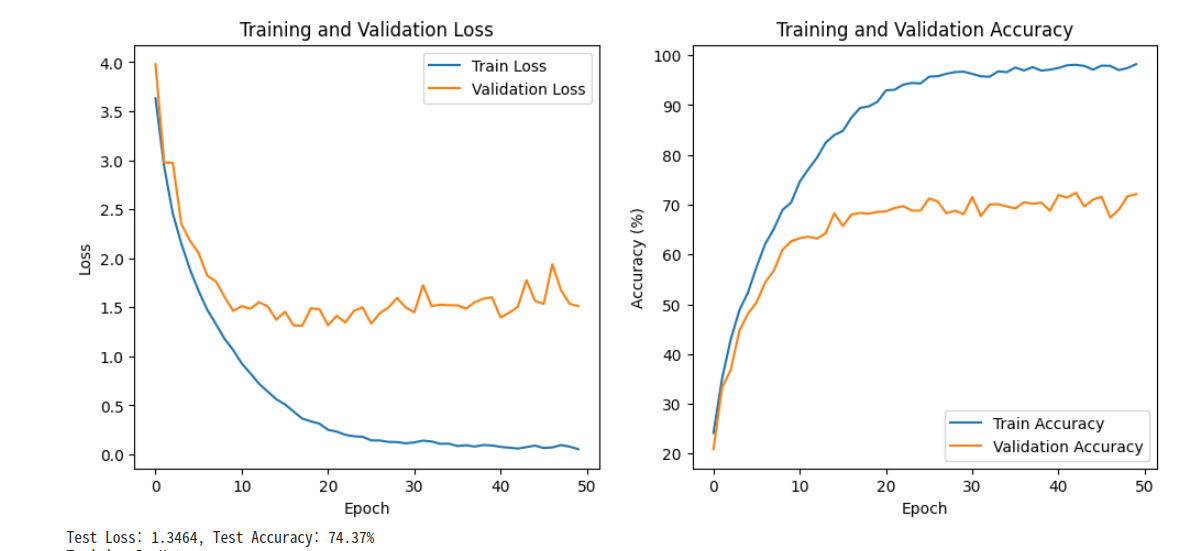

#결과 분석


Caltech-101 데이터셋의 크기를 고려하면, SENet이 각 채널의 중요도를 제대로 학습하기에는 데이터가 충분하지 않을 수 있습니다.

SENet 논문에서는 이미지 분류를 위해 ImageNet 2012 데이터셋을 사용했는데, 이 데이터셋은 약 128만 개의 train 이미지와 5만 개의 validation 이미지를 포함하고 있습니다. 하지만 이번 과제에 사용한 Caltech-101 데이터셋은 전체 이미지가 약 9000장밖에 되지 않으며, 학습용과 테스트용으로 따로 나누어져 있지도 않습니다. 따라서 실험을 위해 데이터를 나누면, 학습할 수 있는 이미지 수는 더 적어집니다.

이렇게 데이터가 부족한 환경에서는 SENet이 각 채널의 중요도를 학습하는 데 어려움을 겪었을 가능성이 큽니다. 반면, ResNet은 층이 깊어도 학습이 잘 되도록 설계된 구조이기 때문에, 제한된 데이터에서도 상대적으로 더 좋은 성능을 낼 수 있었던 것으로 보입니다.